# FEniCS simulation of Eshelby's *elliptical* inclusion problem

The aim of this notebook is to setup a FEniCS simulation of Eshelby's inclusion problem. The framework is linear, plane strain elasticity. We have a matrix in a disk around the origin (radius $R_m$) with an inclusion having the shape of another disk around the origin, with a smaller radius ($R_i < R_m$). The matrix and the inclusion have different elastic modulus ($E$: Young modulus; $\nu$: Poisson ratio) but are both isotropic and linearly elastic:

$$
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
$$

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the plane strain Lamé coefficients :

$$
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
$$

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1,x_2)|_{x_1^2+x_2^2=R_m^2}
%\text{border}
=(-x_2,-x_1)\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


$$
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
-\int_{\Omega} b \cdot v\,\mathrm{d} x\,\mathrm{d} y,
$$

where the body force $b=0$ and $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

![shema](./inclusion_shear.png)

In [1]:
import dolfin
import matplotlib.pyplot as plt
import mshr
import numpy as np
from EshelbyEllipse import *
from sklearn.linear_model import LinearRegression


Text(0.5, 1.0, 'Elliptic inclusion')

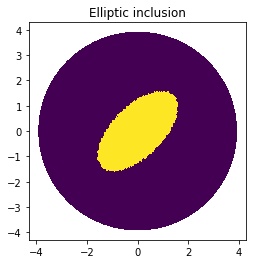

In [2]:
model_tmp = model(A_in=2*1., B_in=1, theta=np.pi/4, R_out=3.9, h=0.35/8)
model_tmp.mesh_generator()
subdomain_data_2d = dolfin.MeshFunction("size_t", model_tmp.mesh, dim=2, value=model_tmp.mesh.domains())
dolfin.plot(subdomain_data_2d)
plt.title('Elliptic inclusion')

In [3]:
model_fine = model(A_in=2*1., B_in=1, theta=np.pi/4, R_out=3.9, h=0.35)
model_fine.mesh_generator()
elliptic_sol_fine = solution(materio, model_fine)
elliptic_sol_fine.solve(model_fine)
elliptic_sol_fine.post_processing(model_fine)

In [4]:
usol_max = np.max(np.abs(elliptic_sol_fine.usol.compute_vertex_values()))
usol_uniform = elliptic_sol_fine.usol/usol_max

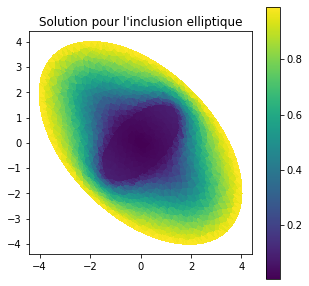

In [5]:
plt.figure(figsize=[5, 5])
plt.colorbar(dolfin.plot(usol_uniform, mode='displacement'))
plt.title('Solution pour l\'inclusion elliptique')
plt.savefig('inclusion_elliptic.png', dpi=300)

Text(0.5, 1.0, "$\\varepsilon_{xy}$ pour l'inclusion elliptique")

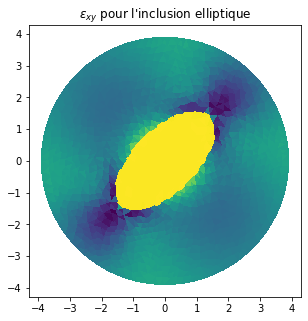

In [9]:
plt.figure(figsize=[5, 5])
dolfin.plot(elliptic_sol_fine.strain_field[2])
plt.title(r'$\varepsilon_{xy}$ pour l' + '\'inclusion elliptique')

## Convergence analysis for the elliptic inclusion rotated on angle $\theta = 45^\circ$

In [10]:
mesh_size = [4*0.35, 2*0.35, 0.35, 0.35/2, 0.35/4, 0.35/6, 0.35/8]
A = [0.25, 0.5, 1.5, 2]
errors_H1 = np.zeros((len(A), len(mesh_size)))
errors_L2 = np.zeros((len(A), len(mesh_size)))

for i, ratio in enumerate(A):
    model_fine = model(A_in=ratio*1., B_in=1, theta=np.pi/4, R_out=3.9, h=0.35/10)
    model_fine.mesh_generator()
    elliptic_sol_fine = solution(materio, model_fine)
    elliptic_sol_fine.solve(model_fine)
    elliptic_sol_fine.usol.set_allow_extrapolation(True)

    for j, h in enumerate(mesh_size):
        model_tmp = model(A_in=ratio*1., B_in=1, theta=np.pi/4, R_out=3.9, h=h)
        model_tmp.mesh_generator()
        elliptic_sol = solution(materio, model_tmp)
        elliptic_sol.solve(model_tmp)

        errors_L2[i,j] = dolfin.errornorm(elliptic_sol_fine.usol, elliptic_sol.usol, 'L2') / dolfin.norm(elliptic_sol_fine.usol, 'L2')
        errors_H1[i,j] = dolfin.errornorm(elliptic_sol_fine.usol, elliptic_sol.usol, 'H1') / dolfin.norm(elliptic_sol_fine.usol, 'H1')

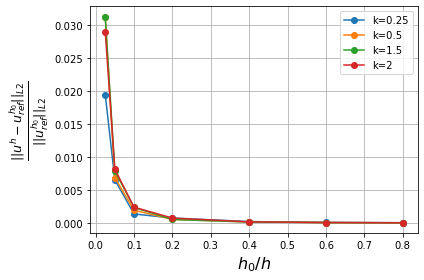

In [11]:
for i, ratio in enumerate(A):
    plt.plot(0.35/np.array(mesh_size)/10, errors_L2[i,:], '-o', label='k=' + str(ratio))
plt.grid()
plt.xlabel(r'$h_0/h$', fontsize=16)
plt.ylabel(r'$\frac{|| u^h - u^{h_0}_{ref} ||_{L2}}{|| u^{h_0}_{ref} ||_{L2}}$', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig('ellipse_coverg.png', dpi=300)

## Convergence rate

### L2 space

In [14]:
log_errors.shape
log_mesh_size_h.shape

(7,)

In [15]:
log_mesh_size_h = np.log(np.array(mesh_size))
log_errors = np.log(errors_L2)

lin_reg = LinearRegression()

for i, ratio in enumerate(A):
    lin_reg.fit(X=log_mesh_size_h.reshape(-1, 1), y=log_errors[i,:].reshape(-1, 1))
    print('k =',ratio, ':',lin_reg.coef_[0][0])

k = 0.25 : 1.7081660031699042
k = 0.5 : 1.9543521499934815
k = 1.5 : 1.9830180004766356
k = 2 : 1.9131565586657195


### H1 space

In [16]:
log_mesh_size_h = np.log(np.array(mesh_size))
log_errors = np.log(errors_H1)

lin_reg = LinearRegression()

for i, ratio in enumerate(A):
    lin_reg.fit(X=log_mesh_size_h.reshape(-1, 1), y=log_errors[i,:].reshape(-1, 1))
    print('k =',ratio, ':',lin_reg.coef_[0][0])

k = 0.25 : 0.7711971348254946
k = 0.5 : 0.8951773145211637
k = 1.5 : 0.9275815331105522
k = 2 : 0.9002758735208665
